# Librerías

In [37]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image, ImageDraw
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.optim as optim

In [3]:
# Ruta a los archivos
image_dir = "/kaggle/input/airplanes-detection/airplanes/airplanes"
csv_path = "/kaggle/input/airplanes-detection/Airplanes.csv"


In [6]:
# Listar imágenes
print(os.listdir(image_dir)[:10]) 

# Leer CSV
df = pd.read_csv(csv_path)
print(df.head())


['image_0612.jpg', 'image_0755.jpg', 'image_0178.jpg', 'image_0777.jpg', 'image_0073.jpg', 'image_0123.jpg', 'image_0770.jpg', 'image_0219.jpg', 'image_0270.jpg', 'image_0188.jpg']
   Unnamed: 0           Image  x_top  y_top  x_bottom  y_bottom      label
0           0  image_0001.jpg     30    137        49       349  Airplanes
1           0  image_0002.jpg     35    153        59       342  Airplanes
2           0  image_0003.jpg     36    135        47       331  Airplanes
3           0  image_0004.jpg     24    141        47       342  Airplanes
4           0  image_0005.jpg     18    146        48       339  Airplanes


# Graficar etiquetas en imágenes

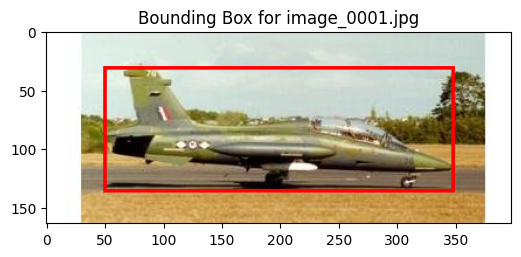

Caja normalizada para image_0001.jpg: [0.12311557788944724, 0.18292682926829268, 0.7537688442211056, 0.6524390243902439]


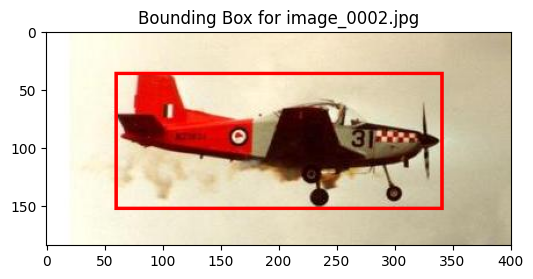

Caja normalizada para image_0002.jpg: [0.14713216957605985, 0.19021739130434784, 0.7057356608478803, 0.6413043478260869]


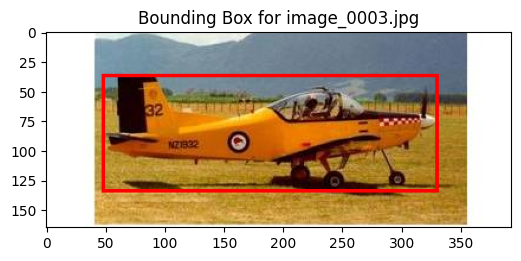

Caja normalizada para image_0003.jpg: [0.11959287531806616, 0.21818181818181817, 0.72264631043257, 0.6]


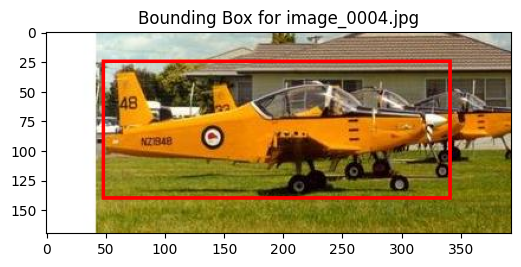

Caja normalizada para image_0004.jpg: [0.11959287531806616, 0.1411764705882353, 0.7506361323155216, 0.6882352941176471]


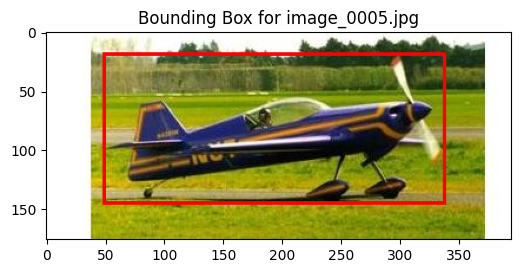

Caja normalizada para image_0005.jpg: [0.12151898734177215, 0.10227272727272728, 0.7367088607594937, 0.7272727272727273]


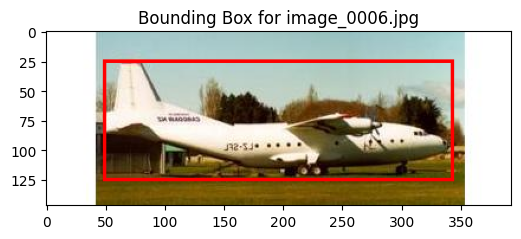

Caja normalizada para image_0006.jpg: [0.12213740458015267, 0.16326530612244897, 0.7531806615776081, 0.6938775510204082]


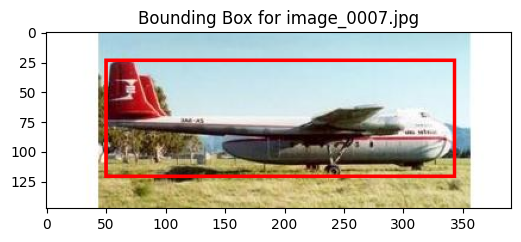

Caja normalizada para image_0007.jpg: [0.12531969309462915, 0.1554054054054054, 0.7544757033248082, 0.668918918918919]


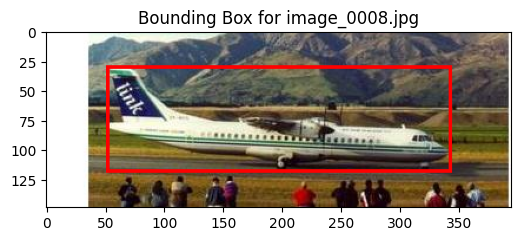

Caja normalizada para image_0008.jpg: [0.1291139240506329, 0.19463087248322147, 0.7417721518987341, 0.6040268456375839]


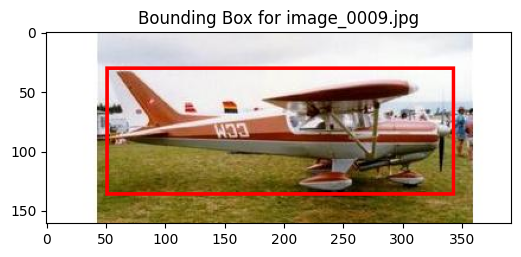

Caja normalizada para image_0009.jpg: [0.12755102040816327, 0.18012422360248448, 0.75, 0.6708074534161491]


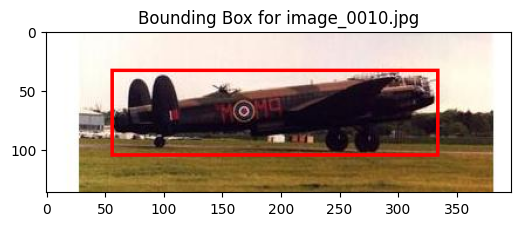

Caja normalizada para image_0010.jpg: [0.1385390428211587, 0.23357664233576642, 0.7052896725440806, 0.5401459854014599]
Caja normalizada para image_0011.jpg: [0.14536340852130325, 0.21604938271604937, 0.7167919799498746, 0.5864197530864198]
Caja normalizada para image_0012.jpg: [0.12342569269521411, 0.16233766233766234, 0.743073047858942, 0.6298701298701299]
Caja normalizada para image_0013.jpg: [0.12244897959183673, 0.17613636363636365, 0.7551020408163265, 0.6534090909090909]
Caja normalizada para image_0014.jpg: [0.13819095477386933, 0.24342105263157895, 0.7386934673366834, 0.5526315789473685]
Caja normalizada para image_0015.jpg: [0.14841849148418493, 0.19597989949748743, 0.7104622871046229, 0.6231155778894473]
Caja normalizada para image_0016.jpg: [0.15051020408163265, 0.3157894736842105, 0.6836734693877551, 0.4853801169590643]
Caja normalizada para image_0017.jpg: [0.15538847117794485, 0.21264367816091953, 0.7142857142857143, 0.6091954022988506]
Caja normalizada para image_0018.jp

In [61]:
# Función para convertir coordenadas
def corners_to_coco(x_top, y_top, x_bottom, y_bottom):
    x      = x_bottom
    y      = x_top
    width  = y_bottom - x_bottom
    height = y_top    - x_top
    return [x, y, width, height]

dataset = []
count = 0

sample_images = df  # Tomamos todas las muestras

for index, row in sample_images.iterrows():
    image_name = row["Image"]
    image_path = os.path.join(image_dir, image_name)
    
    # Extraemos las coordenadas originales
    x_top = int(row["x_top"])
    y_top = int(row["y_top"])
    x_bottom = int(row["x_bottom"])
    y_bottom = int(row["y_bottom"])
    
    # Ordenamos las coordenadas antes de pasarlas a la función
    x_top, x_bottom = sorted([x_top, x_bottom])
    y_top, y_bottom = sorted([y_top, y_bottom])
    
    # Usamos la función (en pixeles)
    x, y, width, height = corners_to_coco(x_top, y_top, x_bottom, y_bottom)
    
    # Calculamos la esquina inferior derecha
    x2 = x + width
    y2 = y + height
    
    # Normalizamos los valores (valores entre 0 y 1)
    with Image.open(image_path) as img:
        w_img, h_img = img.size
        bbox_norm = [x / w_img, y / h_img, width / w_img, height / h_img]
        
        # Dibujamos y mostramos solo las primeras 10 imágenes
        if count < 10:
            draw = ImageDraw.Draw(img)
            box = [x, y, x2, y2]
            draw.rectangle(box, outline="red", width=3)
            
            plt.figure(figsize=(6, 6))
            plt.imshow(img)
            plt.title(f"Bounding Box for {image_name}")
            plt.axis("on")
            plt.show()
            
            count += 1
    
    # Guardamos la caja normalizada
    dataset.append({'img_path': image_path, 'bbox_norm': bbox_norm})
    
    print(f"Caja normalizada para {image_name}: {bbox_norm}")

print(f"Total muestras procesadas: {len(dataset)}")


# Modelo extractor de características (convoluciones) + cabeza (regresión de 4 variables)

In [62]:
# Dataset personalizado
class BoundingBoxDataset(Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform
    
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        sample = self.dataset[idx]
        img = Image.open(sample['img_path']).convert("RGB")
        bbox = torch.tensor(sample['bbox_norm'], dtype=torch.float32)
        
        if self.transform:
            img = self.transform(img)
        
        return img, bbox

# Red convolucional + regresión
class BoundingBoxRegressor(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Flatten()
        )
        self.regressor = nn.Linear(64 * 16 * 16, 4)  # Salida de 4 variables
    
    def forward(self, x):
        x = self.features(x)
        x = self.regressor(x)
        return x

# Transformaciones para las imágenes
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

# DataLoader
train_dataset = BoundingBoxDataset(dataset, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)

# Configuración del dispositivo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BoundingBoxRegressor().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Entrenamiento
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    
    for imgs, bboxes in train_loader:
        imgs = imgs.to(device)
        bboxes = bboxes.to(device)
        
        outputs = model(imgs)
        loss = criterion(outputs, bboxes)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * imgs.size(0)
    
    epoch_loss = running_loss / len(train_loader.dataset)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")

print("Entrenamiento finalizado 🚀")

Epoch 1/10, Loss: 0.0224
Epoch 2/10, Loss: 0.0025
Epoch 3/10, Loss: 0.0021
Epoch 4/10, Loss: 0.0021
Epoch 5/10, Loss: 0.0021
Epoch 6/10, Loss: 0.0020
Epoch 7/10, Loss: 0.0020
Epoch 8/10, Loss: 0.0020
Epoch 9/10, Loss: 0.0019
Epoch 10/10, Loss: 0.0018
Entrenamiento finalizado 🚀


# Calculo de IoU de dos rectángulos

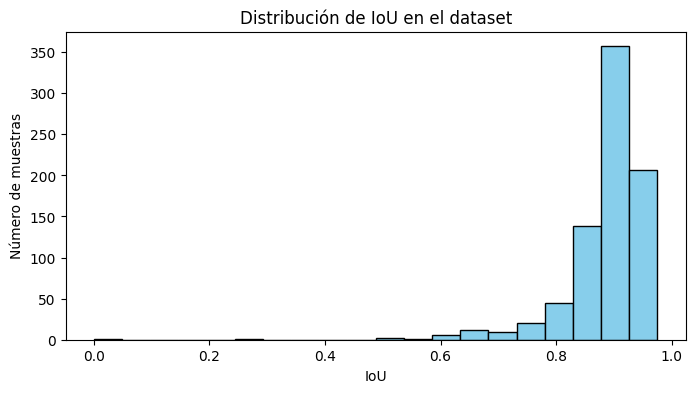

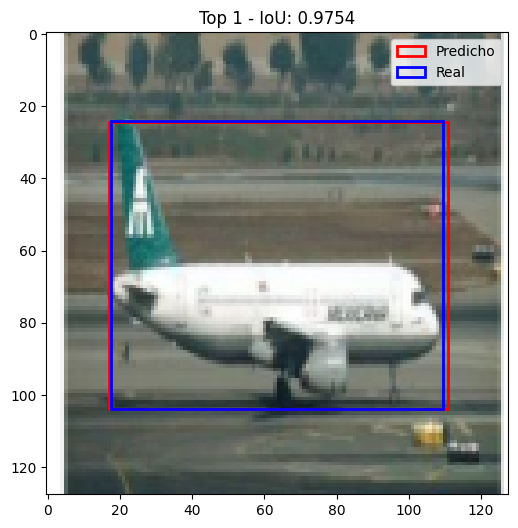

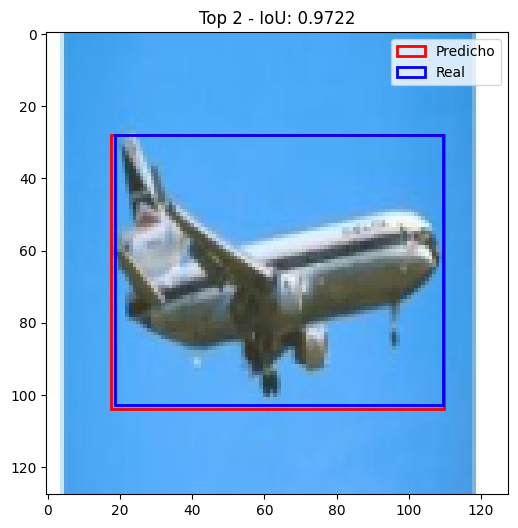

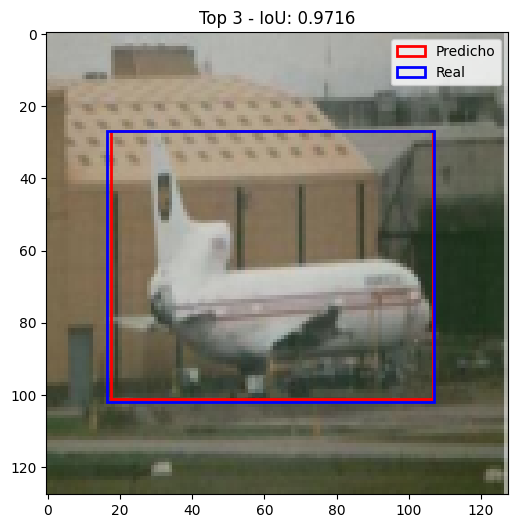

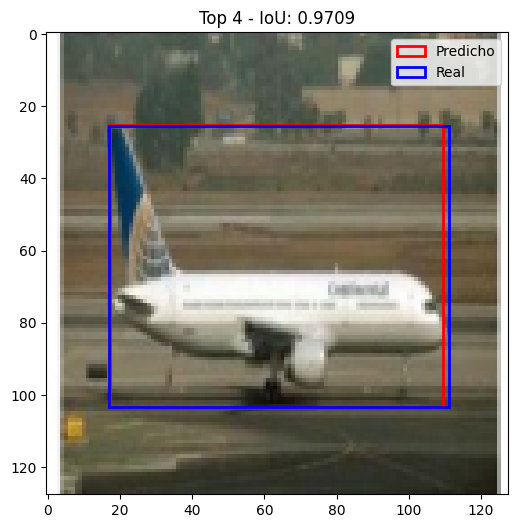

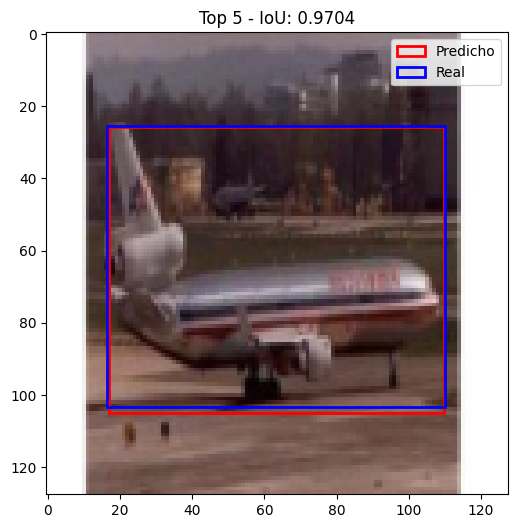

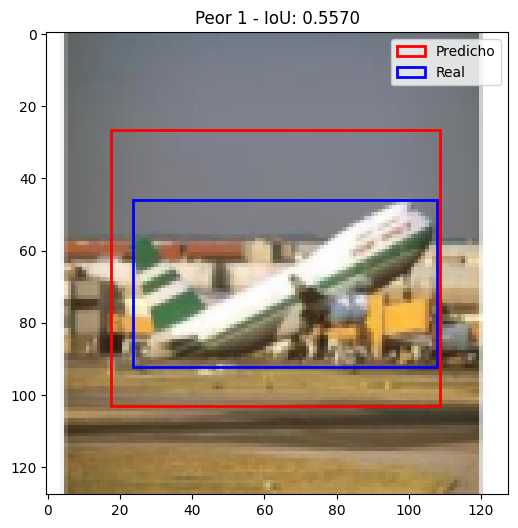

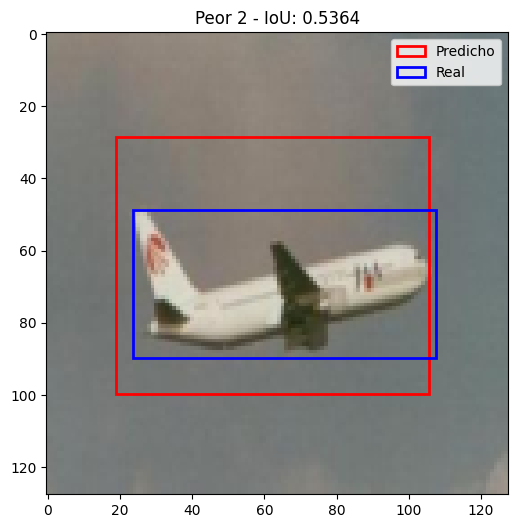

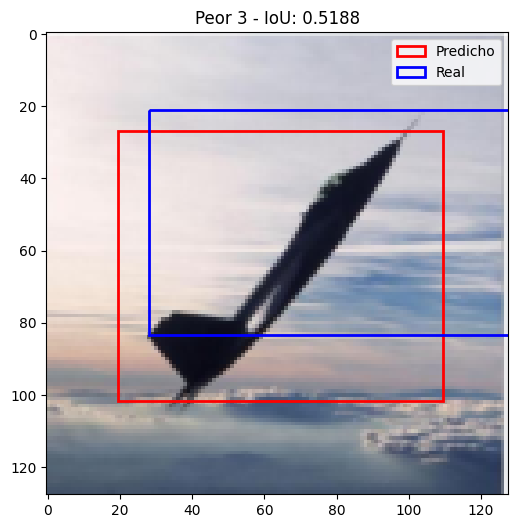

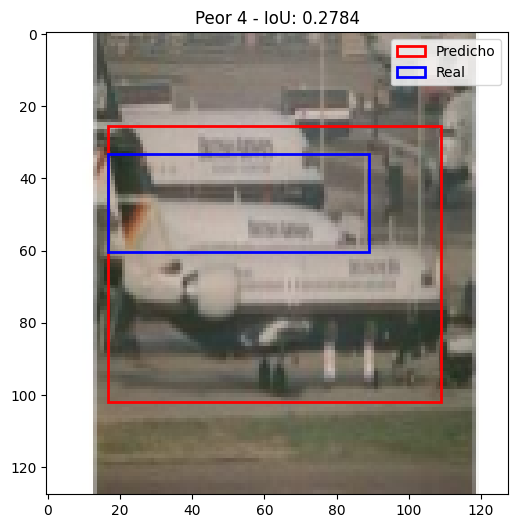

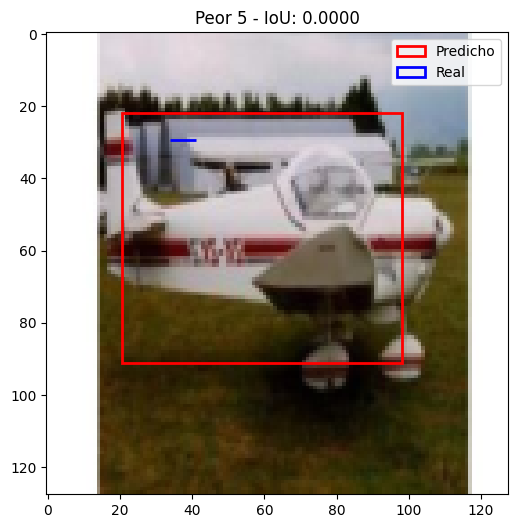

In [66]:
def calculate_iou(box1, box2):
    x1_min, y1_min, w1, h1 = box1
    x1_max = x1_min + w1
    y1_max = y1_min + h1

    x2_min, y2_min, w2, h2 = box2
    x2_max = x2_min + w2
    y2_max = y2_min + h2

    inter_x_min = max(x1_min, x2_min)
    inter_y_min = max(y1_min, y2_min)
    inter_x_max = min(x1_max, x2_max)
    inter_y_max = min(y1_max, y2_max)

    inter_width = max(0, inter_x_max - inter_x_min)
    inter_height = max(0, inter_y_max - inter_y_min)
    inter_area = inter_width * inter_height

    area1 = w1 * h1
    area2 = w2 * h2
    union_area = area1 + area2 - inter_area

    iou = inter_area / union_area if union_area > 0 else 0.0
    return iou

model.eval()
ious_all = []
samples_all = []

with torch.no_grad():
    for imgs, bboxes_true in train_loader:
        imgs = imgs.to(device)
        preds = model(imgs).cpu().numpy()
        targets = bboxes_true.numpy()
        
        batch_size = imgs.shape[0]
        for i in range(batch_size):
            iou = calculate_iou(preds[i], targets[i])
            ious_all.append(iou)
            samples_all.append((imgs[i].cpu(), preds[i], targets[i]))

# Histograma de IoU
plt.figure(figsize=(8, 4))
plt.hist(ious_all, bins=20, color='skyblue', edgecolor='black')
plt.xlabel("IoU")
plt.ylabel("Número de muestras")
plt.title("Distribución de IoU en el dataset")
plt.show()

# Ordenamos por IoU
sorted_samples = sorted(zip(ious_all, samples_all), key=lambda x: x[0], reverse=True)

def denormalize(bbox, w, h):
    x, y, width, height = bbox
    return [x * w, y * h, width * w, height * h]

# Visualizamos las 5 mejores IoU
for i, (iou, (img_tensor, pred_box, true_box)) in enumerate(sorted_samples[:5]):
    img_np = img_tensor.permute(1, 2, 0).numpy()
    w_img, h_img = 128, 128
    
    box1 = denormalize(pred_box, w_img, h_img)
    box2 = denormalize(true_box, w_img, h_img)
    
    fig, ax = plt.subplots(1, figsize=(6, 6))
    ax.imshow(img_np)
    
    rect1 = patches.Rectangle((box1[0], box1[1]), box1[2], box1[3],
                              linewidth=2, edgecolor='red', facecolor='none', label='Predicho')
    rect2 = patches.Rectangle((box2[0], box2[1]), box2[2], box2[3],
                              linewidth=2, edgecolor='blue', facecolor='none', label='Real')
    ax.add_patch(rect1)
    ax.add_patch(rect2)

    plt.legend()
    plt.axis('on')
    plt.title(f"Top {i+1} - IoU: {iou:.4f}")
    plt.show()

# Visualizamos las 5 peores IoU
for i, (iou, (img_tensor, pred_box, true_box)) in enumerate(sorted_samples[-5:]):
    img_np = img_tensor.permute(1, 2, 0).numpy()
    w_img, h_img = 128, 128
    
    box1 = denormalize(pred_box, w_img, h_img)
    box2 = denormalize(true_box, w_img, h_img)
    
    fig, ax = plt.subplots(1, figsize=(6, 6))
    ax.imshow(img_np)
    
    rect1 = patches.Rectangle((box1[0], box1[1]), box1[2], box1[3],
                              linewidth=2, edgecolor='red', facecolor='none', label='Predicho')
    rect2 = patches.Rectangle((box2[0], box2[1]), box2[2], box2[3],
                              linewidth=2, edgecolor='blue', facecolor='none', label='Real')
    ax.add_patch(rect1)
    ax.add_patch(rect2)

    plt.legend()
    plt.axis('on')
    plt.title(f"Peor {i+1} - IoU: {iou:.4f}")
    plt.show()
